# Minimal PyTorch NN: Add a Layer + Swap Activation/Optimizer (Teaching Notebook)

Goal: **see what changes** when we:
- add another hidden layer (more capacity),
- change the **activation** (ReLU vs Tanh vs none),
- change the **optimizer** (SGD vs Adam).

> Note: **SGD is an optimizer**, not an activation. **ReLU is an activation**.  
So this notebook shows both kinds of swaps clearly.


## Local setup (macOS Apple Silicon, e.g. Mac M5) using `uv`

### 1) Install `uv`
```bash
curl -LsSf https://astral.sh/uv/install.sh | sh
```

### 2) Create a project + virtual env + deps
```bash
uv init nn-training-demo
cd nn-training-demo

# Choose a Python version (example: 3.12)
uv python install 3.12
uv python pin 3.12

# Add dependencies
uv add torch torchvision torchaudio jupyterlab matplotlib

# Create/sync the environment
uv sync
```

### 3) Run Jupyter (or use VS Code with Jupyter extension)
```bash
uv run jupyter lab
```

### 4) VS Code kernel tip
If VS Code doesn't show your `uv` env as a kernel, install `ipykernel` into the env:
```bash
uv add ipykernel
uv sync
```
Then restart VS Code and choose the kernel from the top-right **Select Kernel** menu.


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

print("torch:", torch.__version__)


torch: 2.10.0


In [22]:
# Prefer Apple Metal (MPS) on Apple Silicon if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("device:", device)


device: mps


In [23]:
# --- 1) Create a tiny "real-life-ish" dataset (linear regression) ---
# Example: house price vs. square footage (simplified)
# We'll measure:
#   X = home size in *thousands* of square feet (kSqFt)
#   y = price in *thousands* of dollars ($k)
#
# True relationship (unknown to the model):  price ≈ 150 * size + 50  (+ noise)
# This keeps numbers in a nice range for teaching and stable training.

torch.manual_seed(0)

n = 200  # keep it small
X = torch.linspace(0.5, 3.5, n).unsqueeze(1)          # kSqFt, shape (n, 1)
noise = 12.0 * torch.randn(n, 1)                      # ~$12k noise
y = 150.0 * X + 50.0 + noise                          # $k, shape (n, 1)

dataset = TensorDataset(X, y)
print("X:", X.shape, "y:", y.shape)
print("Example: size =", float(X[0]), "kSqFt -> price =", float(y[0]), "$k")


X: torch.Size([200, 1]) y: torch.Size([200, 1])
Example: size = 0.5 kSqFt -> price = 111.48992156982422 $k


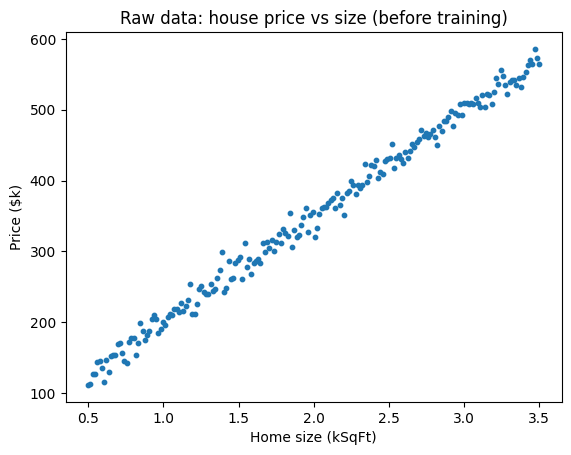

In [24]:
# Plot the raw dataset (before any training)
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, y, s=10)
plt.xlabel("Home size (kSqFt)")
plt.ylabel("Price ($k)")
plt.title("Raw data: house price vs size (before training)")
plt.show()

## 2) Define model variants

We'll compare these model choices:

**A) Baseline (1 hidden layer + ReLU)**
- Linear(1→8) → ReLU → Linear(8→1)

**B) Deeper (2 hidden layers + ReLU)**
- Linear(1→8) → ReLU → Linear(8→8) → ReLU → Linear(8→1)

**C) Activation swap**
- Replace ReLU with Tanh (a "squashing" activation)

**D) No activation**
- Linear(1→8) → Linear(8→1)  
  (This is effectively *still linear overall*; good to demonstrate why activations matter.)


In [25]:
def make_model(kind: str) -> nn.Module:
    if kind == "baseline_relu":
        return nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
    if kind == "deeper_relu":
        return nn.Sequential(
            nn.Linear(1, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
        )
    if kind == "baseline_tanh":
        return nn.Sequential(
            nn.Linear(1, 8),
            nn.Tanh(),
            nn.Linear(8, 1),
        )
    if kind == "no_activation":
        return nn.Sequential(
            nn.Linear(1, 8),
            nn.Linear(8, 1),
        )
    raise ValueError(f"Unknown kind: {kind}")

def count_params(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


## 3) One training function (shows the 5-step loop)

Inside each batch:
1) forward pass  
2) compute loss  
3) `zero_grad()`  
4) `backward()`  
5) `step()`


In [26]:
def train_model(model: nn.Module, optimizer_name: str, lr: float, epochs: int = 50, batch_size: int = 32, seed: int = 0):
    # Reset seeds for fair-ish comparisons
    torch.manual_seed(seed)

    # Fresh loader with deterministic shuffle (as much as possible)
    g = torch.Generator()
    g.manual_seed(seed)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=g)

    model = model.to(device)
    loss_fn = nn.MSELoss()

    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'sgd' or 'adam'")

    history = []
    for epoch in range(1, epochs + 1):
        model.train()
        running = 0.0

        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)

            # (1) forward
            y_pred = model(xb)

            # (2) loss
            loss = loss_fn(y_pred, yb)

            # (3) clear grads
            optimizer.zero_grad()

            # (4) backprop
            loss.backward()

            # (5) update
            optimizer.step()

            running += loss.item() * xb.size(0)

        epoch_loss = running / len(dataset)
        history.append(epoch_loss)

    # Predictions for visualization
    model.eval()
    with torch.no_grad():
        y_hat = model(X.to(device)).cpu()

    return history, y_hat, model


## 4) Run experiments

We'll keep the problem, data, and epochs the same, and compare:

### Part 1 — Add a layer (capacity increase)
- baseline_relu + SGD
- deeper_relu + SGD

### Part 2 — Swap activation
- baseline_relu + SGD
- baseline_tanh + SGD
- no_activation + SGD

### Part 3 — Swap optimizer (SGD vs Adam)
- baseline_relu + SGD
- baseline_relu + Adam

> Tip: hyperparameters matter. A deeper model sometimes benefits from a slightly smaller learning rate.


In [35]:
experiments = [
    # Part 1: add a layer
    {"name": "baseline_relu + SGD(lr=0.10)", "kind": "baseline_relu", "opt": "sgd", "lr": 0.10},
    {"name": "deeper_relu + SGD(lr=0.05)",  "kind": "deeper_relu",  "opt": "sgd", "lr": 0.05},

    # Part 2: activation swap
    {"name": "baseline_tanh + SGD(lr=0.10)", "kind": "baseline_tanh", "opt": "sgd", "lr": 0.10},
    {"name": "no_activation + SGD(lr=0.10)", "kind": "no_activation", "opt": "sgd", "lr": 0.10},

    # Part 3: optimizer swap
    {"name": "baseline_relu + Adam(lr=0.05)", "kind": "baseline_relu", "opt": "adam", "lr": 0.005},
]

results = {}

for cfg in experiments:
    torch.manual_seed(0)  # make init comparable
    model = make_model(cfg["kind"])
    params = count_params(model)

    hist, y_hat, trained = train_model(model, cfg["opt"], cfg["lr"], epochs=100, batch_size=32, seed=0)
    results[cfg["name"]] = {"history": hist, "y_hat": y_hat, "params": params}

    print(f"{cfg['name']:<30} | params={params:<4} | final_loss={hist[-1]:.4f}")


baseline_relu + SGD(lr=0.10)   | params=25   | final_loss=17004.1705
deeper_relu + SGD(lr=0.05)     | params=97   | final_loss=16957.5914
baseline_tanh + SGD(lr=0.10)   | params=25   | final_loss=17446.5484
no_activation + SGD(lr=0.10)   | params=25   | final_loss=nan
baseline_relu + Adam(lr=0.05)  | params=25   | final_loss=21905.6684


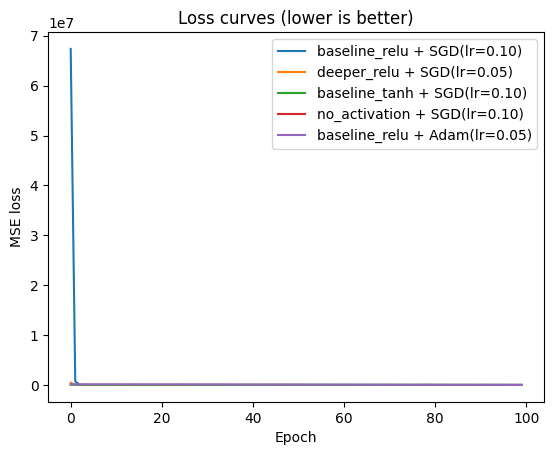

In [36]:
# --- Compare loss curves ---
plt.figure()
for name, r in results.items():
    plt.plot(r["history"], label=name)
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Loss curves (lower is better)")
plt.legend()
plt.show()


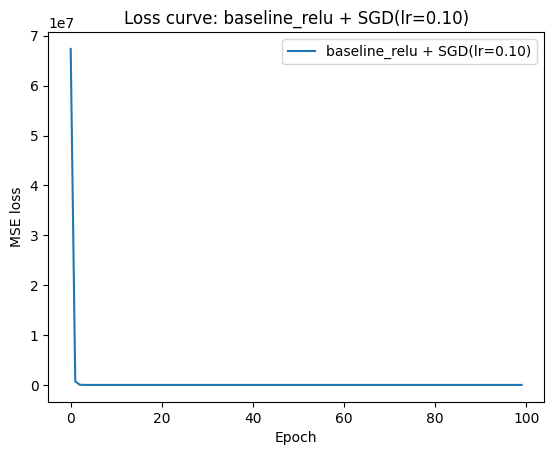

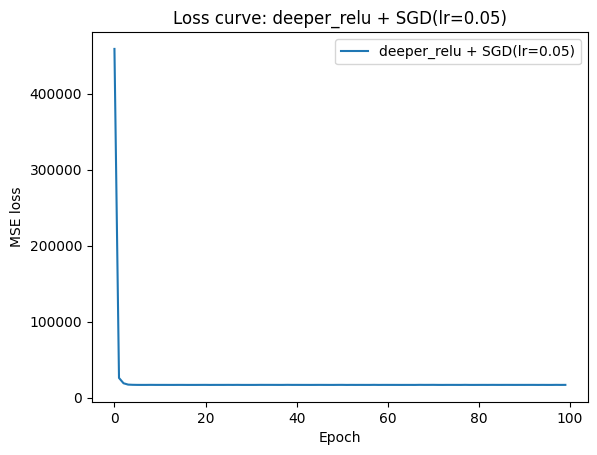

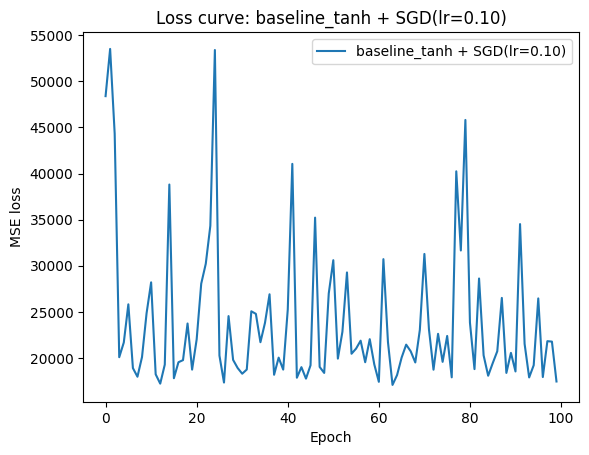

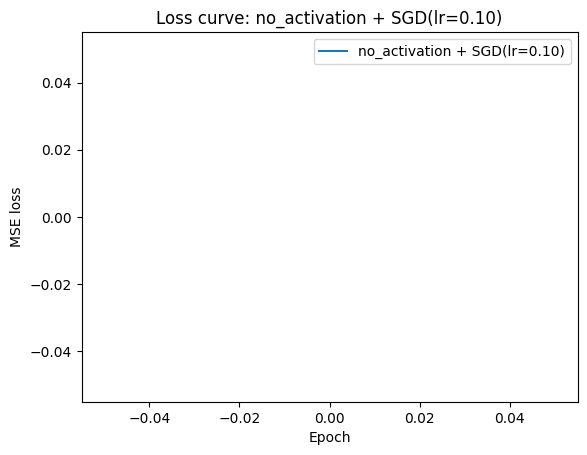

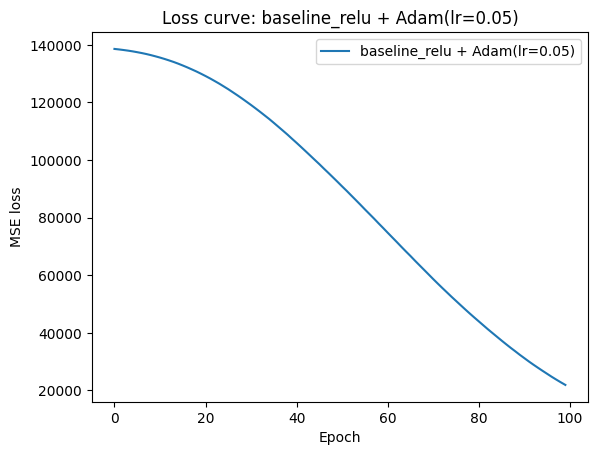

In [37]:
import matplotlib.pyplot as plt

# One plot per experiment
for name, r in results.items():
    plt.figure()
    plt.plot(r["history"], label=name)
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title(f"Loss curve: {name}")
    plt.legend()
    plt.show()

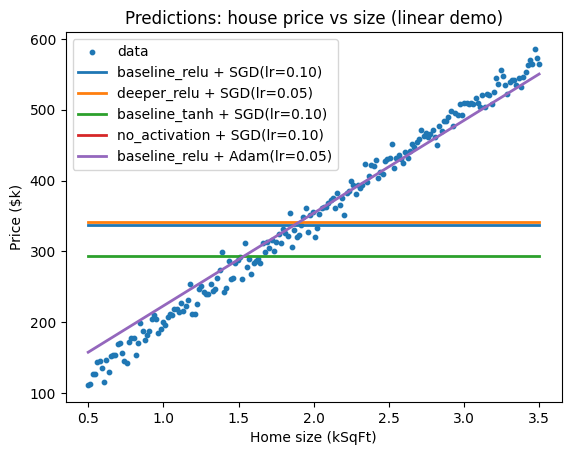

In [30]:
# --- Compare predictions ---
# We'll plot the true data (scatter) and each model's prediction (line).
plt.figure()
plt.scatter(X, y, s=10, label="data")

for name, r in results.items():
    plt.plot(X, r["y_hat"], linewidth=2, label=name)

plt.xlabel("Home size (kSqFt)")
plt.ylabel("Price ($k)")
plt.title("Predictions: house price vs size (linear demo)")
plt.legend()
plt.show()


## 5) Takeaways

**Adding a hidden layer (more depth/capacity):**
- Can fit more complex patterns *in general*.
- On this simple linear-ish dataset, you may not need extra capacity.
- Deeper models sometimes need different learning rates to train smoothly.

**Changing activation:**
- ReLU often trains quickly and avoids saturating gradients.
- Tanh can be fine but may train differently because it “squashes” values.
- No activation makes the network effectively linear overall → it can’t represent non-linear relationships.

**Changing optimizer:**
- SGD is simple and transparent; great for teaching.
- Adam often converges faster/easier with less tuning (but is less “bare metal”).
